In [11]:

############# Typing #############
from typing import Annotated, Sequence, TypedDict

########### OPEN AI ####################
from langchain_core.messages import BaseMessage # Foundational class for all message types in Langgraph
from langchain_core.messages import ToolMessage # Passes data class back to LLM after it calls a tool such as the content and tool call id
from langchain_core.messages import SystemMessage  # Message providing instructions to the LLM
from langchain_core.messages import HumanMessage # Passing HumanMessage
from langchain_core.messages import AIMessage # Message generated by the LLM
from langchain_openai import ChatOpenAI

##### Tools #############
from langchain_core.tools import tool
from langchain_tavily import TavilySearch


######## Langgraph Components #########
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode


######### ENV #########
from dotenv import load_dotenv

In [37]:
load_dotenv()


True

In [38]:
class AgentState(TypedDict):
    ##### HumanMessage and AIMessage --> Datatypes for langchain
    messages : Annotated[Sequence[BaseMessage], add_messages]
    initialize_chat : int


In [39]:
######## Initialize Tools and Models ##########

# list of all tools

tools = [TavilySearch(max_results=5,topic="news")]

##### Model (Binding Tools) #########
llm = ChatOpenAI(model="gpt-4o").bind_tools(tools)

In [ ]:


# AGENT NODE FUNCTION ######
def ReAct(state: AgentState) -> AgentState:

    ####### define system prompt ########
    system_prompt = SystemMessage(content=
   "You are my AI Assistant, please answer my query to the best of your ability")

    
    response = llm.invoke([system_prompt] + state["messages"])
    
    return {"messages": [response]}



In [112]:
#### CONDITIONAL FUNCTIONS ####

def react_function(state: AgentState) -> AgentState:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

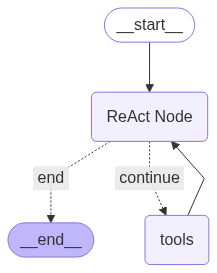

In [117]:
######## GRAPH #######

graph = StateGraph(AgentState)

###### (A) Add nodes ######  

### 1. Chat Nodes ####
graph.add_node("ReAct Node", ReAct)

### 2. Tool Node #####
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)


#### (B) Add edges ######


graph.add_edge(START, "ReAct Node")


graph.add_conditional_edges(
    "ReAct Node",
    react_function,
    {
        "continue": "tools",
        "end" : END
    }
)

graph.add_edge("tools", "ReAct Node")


agent =  graph.compile()
agent

In [118]:
# Helper Function 
def stream_agent(stream, show_stream=True):
    output = []
    for s in stream:
        message = s["messages"][-1]
        if show_stream==True:
            if isinstance(message, tuple):
                print(message)
            else:
                message.pretty_print()
            
        output.append(message)

    return output

In [122]:
inputs = {"messages": [("user",  "What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines")],
          "initialize_chat" : 1}

output  = stream_agent(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_gKpsXEuMiESs34679VCg8Spq)
 Call ID: call_gKpsXEuMiESs34679VCg8Spq
  Args:
    query: latest news this week in United States Politics
    search_depth: advanced
    time_range: week
    topic: news
  tavily_search (call_ULOqmxcyHxRzFkidfpoHA3GG)
 Call ID: call_ULOqmxcyHxRzFkidfpoHA3GG
  Args:
    query: latest news this week in United States Sports
    search_depth: advanced
    time_range: week
    topic: news
  tavily_search (call_cIbAl1FgadGJfjE2R1QRi1Ye)
 Call ID: call_cIbAl1FgadGJfjE2R1QRi1Ye
  Args:
    query: latest news this week in United States Technology
    search_depth: advanced
    time_range: week
    topic: ne

In [ ]:
conversation_history = []
initialize_chat  = 1
user_input = input("Enter: ")
while user_input!= "exit":

    conversation_history.append(HumanMessage(content=user_input))
    print("User: ",user_input)

    
    if user_input == "":

        conversation_history.append("Nothing was typed by the user can you ask again what they wanted based on the previous context.")

    inputs = {"messages": [("user", "\n".join([i.content for i in conversation_history]))],
                "initialize_chat" : initialize_chat} 


    result = stream_agent(agent.stream(inputs, stream_mode="values"), show_stream=False)

    print("AI:", result[-1].content)
    
    conversation_history  = [i for i in result if i.type!='tool']

    initialize_chat  = 0
    
    user_input = input("Enter: ")

User:  "What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines")],           "initialize_chat" : 1}
AI: Here are the latest news headlines from the United States this week in Politics, Sports, Technology, and AI, along with some context:

### Politics
1. **[The state of labor laws halfway through 2025 - Politico](https://www.politico.com/newsletters/weekly-shift/2025/06/09/the-state-of-labor-laws-halfway-through-2025-00394068)**
   - Politico explores the recent developments in employment, labor, and immigration politics and policy. This includes discussions around the Trump administration's interactions with El Salvador and labor policies.

2. **[GOP senator reveals what Trump said in White House meeting - CNN](https://www.cnn.com/2025/06/04/politics/video/the-lead-gop-donald-trump-budget-bill-medicaid-spending-big-beautiful)**
   - The article discusses a GOP senator's 

In [ ]:
with open("outputs/logging.txt", "w") as file:
    file.write("Your Conversation Log:\n")
    
    for message in conversation_history:
        if isinstance(message, HumanMessage):
            file.write(f"You: {message.content}\n")
        elif isinstance(message, AIMessage):
            file.write(f"AI: {message.content}\n\n")
    file.write("End of Conversation")

print("Conversation saved to logging.txt")

Conversation saved to logging.txt
